In [10]:
import joblib

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score, roc_curve, RocCurveDisplay
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics


**Read and shuffle the dataset**

In [12]:
df = pd.read_csv('datasets/quick_checkup/symptom-disease.csv')
df = shuffle(df,random_state=42)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
373,Acne,skin_rash,blackheads,scurring,NaN
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring
1550,Hyperthyroidism,fatigue,mood_swings,weight_loss,restlessness
3081,AIDS,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts
3857,Chronic cholestasis,itching,vomiting,yellowish_skin,nausea


**Removing Hyphen from strings**

In [13]:
for col in df.columns:
    
    df[col] = df[col].str.replace('_',' ')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
373,Acne,skin rash,blackheads,scurring,NaN
4916,Acne,skin rash,pus filled pimples,blackheads,scurring
1550,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness
3081,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts
3857,Chronic cholestasis,itching,vomiting,yellowish skin,nausea


**Dataset characteristics**

In [14]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
count,4920,4920,4920,4920,4572
unique,41,34,48,54,50
top,Acne,vomiting,vomiting,fatigue,high fever
freq,120,822,870,726,378


**Check for null and NaN values**

In [15]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

           count
Disease        0
Symptom_1      0
Symptom_2      0
Symptom_3      0
Symptom_4    348


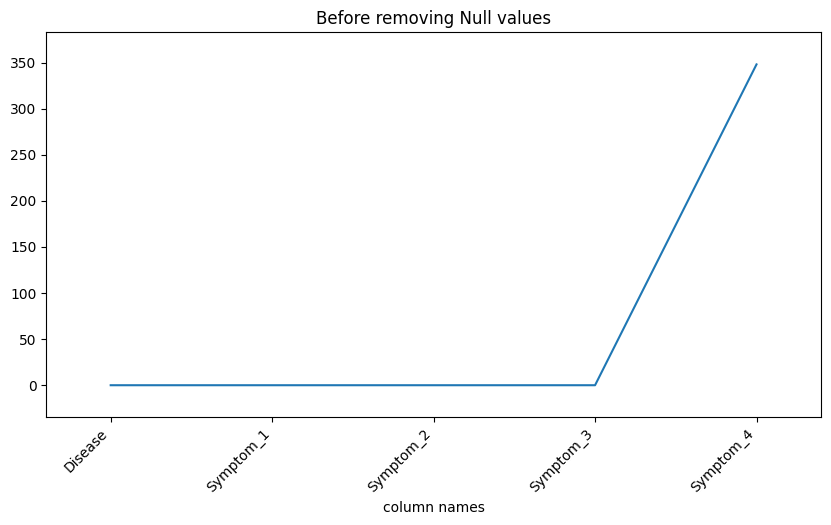

In [16]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

**Remove the trailing space from the symptom columns**

In [17]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,Acne,skin rash,blackheads,scurring,NaN
1,Acne,skin rash,pus filled pimples,blackheads,scurring
2,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness
3,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts
4,Chronic cholestasis,itching,vomiting,yellowish skin,nausea


**Fill the NaN values with zero**

In [18]:
df = df.fillna(0)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,Acne,skin rash,blackheads,scurring,0
1,Acne,skin rash,pus filled pimples,blackheads,scurring
2,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness
3,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts
4,Chronic cholestasis,itching,vomiting,yellowish skin,nausea


**Symptom severity rank**

In [20]:
df1 = pd.read_csv('datasets/quick_checkup/Symptom-severity.csv')
df1['Symptom'] = df1['Symptom'].str.replace('_',' ')
df1.head()

,Symptom,weight
0,itching,1
1,skin rash,3
2,nodal skin eruptions,4
3,continuous sneezing,4
4,shivering,5


**Get overall list of symptoms**

In [21]:
df1['Symptom'].unique()

array(['itching', 'skin rash', 'nodal skin eruptions',
       'continuous sneezing', 'shivering', 'chills', 'joint pain',
       'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting',
       'vomiting', 'burning micturition', 'spotting urination', 'fatigue',
       'weight gain', 'anxiety', 'cold hands and feets', 'mood swings',
       'weight loss', 'restlessness', 'lethargy', 'patches in throat',
       'irregular sugar level', 'cough', 'high fever', 'sunken eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish skin', 'dark urine', 'nausea',
       'loss of appetite', 'pain behind the eyes', 'back pain',
       'constipation', 'abdominal pain', 'diarrhoea', 'mild fever',
       'yellow urine', 'yellowing of eyes', 'acute liver failure',
       'fluid overload', 'swelling of stomach', 'swelled lymph nodes',
       'malaise', 'blurred and distorted vision', 'phlegm',
       'throat irritation', 'redness of eyes', 'sinus pressu

**Encode symptoms in the data with the symptom rank**

In [22]:
vals = df.values
symptoms = df1['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df1[df1['Symptom'] == symptoms[i]]['weight'].values[0]
    
d = pd.DataFrame(vals, columns=cols)
d.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,Acne,3,2,2,0
1,Acne,3,2,2,2
2,Hyperthyroidism,4,3,3,5
3,AIDS,3,6,7,5
4,Chronic cholestasis,1,5,3,5


**Assign symptoms with no rank to zero**

In [23]:
d = d.replace('dischromic  patches', 0)
d = d.replace('spotting  urination',0)
df = d.replace('foul smell of urine',0)
df.head(10)

C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_18212\969436745.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('dischromic  patches', 0)
C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_18212\969436745.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('spotting  urination',0)
C:\Users\Josia Given S\AppData\Local\Temp\ipykernel_18212\969436745.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly 

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4
0,Acne,3,2,2,0
1,Acne,3,2,2,2
2,Hyperthyroidism,4,3,3,5
3,AIDS,3,6,7,5
4,Chronic cholestasis,1,5,3,5
5,Hypertension,3,7,4,4
6,Hypoglycemia,5,4,4,3
7,Arthritis,2,4,5,2
8,Hepatitis B,1,4,2,3
9,Migraine,3,5,3,5


**Check if entire columns have zero values so we can drop those values**

In [24]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

           count
Disease        0
Symptom_1      0
Symptom_2      0
Symptom_3      0
Symptom_4      0


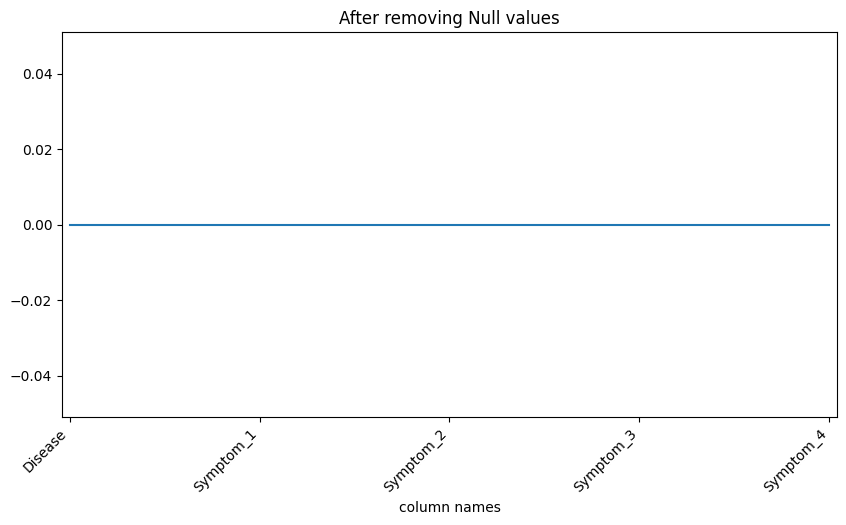

In [25]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('After removing Null values')
plt.xlabel('column names')
plt.margins(0.01)
plt.show()

In [26]:
print("Number of symptoms used to identify the disease ",len(df1['Symptom'].unique()))
print("Number of diseases that can be identified ",len(df['Disease'].unique()))

Number of symptoms used to identify the disease  132
Number of diseases that can be identified  41


**Get the names of diseases from data**

In [27]:
df['Disease'].unique()

array(['Acne', 'Hyperthyroidism', 'AIDS', 'Chronic cholestasis',
       'Hypertension', 'Hypoglycemia', 'Arthritis', 'Hepatitis B',
       'Migraine', 'Urinary tract infection', 'Diabetes', 'Hepatitis D',
       'Psoriasis', 'Alcoholic hepatitis', 'Dimorphic hemmorhoids(piles)',
       'Hepatitis E', 'Cervical spondylosis', 'Bronchial Asthma',
       'hepatitis A', 'Allergy', 'Hepatitis C', 'Pneumonia',
       'Hypothyroidism', 'Gastroenteritis', 'Varicose veins', 'Jaundice',
       'Drug Reaction', '(vertigo) Paroymsal  Positional Vertigo',
       'Heart attack', 'Tuberculosis', 'Typhoid', 'Common Cold',
       'Peptic ulcer diseae', 'Paralysis (brain hemorrhage)',
       'Fungal infection', 'Impetigo', 'GERD', 'Dengue', 'Malaria',
       'Chicken pox', 'Osteoarthristis'], dtype=object)

### Select the features as symptoms column and label as Disease column

Explination: A **feature** is an input; **label** is an output.
A feature is one column of the data in your input set. For instance, if you're trying to predict the type of pet someone will choose, your input features might include age, home region, family income, etc. The label is the final choice, such as dog, fish, iguana, rock, etc.

Once you've trained your model, you will give it sets of new input containing those features; it will return the predicted "label" (pet type) for that person.

In [28]:
data = df.iloc[:,1:].values
labels = df['Disease'].values

## Splitting the dataset to training (80%) and testing (20%)

Separating data into training and testing sets is an important part of evaluating data mining models. Typically, when you separate a data set into a training set and testing set, most of the data is used for training, and a smaller portion of the data is used for testing. By using similar data for training and testing, you can minimize the effects of data discrepancies and better understand the characteristics of the model.
After a model has been processed by using the training set, we test the model by making predictions against the test set. Because the data in the testing set already contains known values for the attribute that you want to predict, it is easy to determine whether the model's guesses are correct.

* Train Dataset: Used to fit the machine learning model.
* Test Dataset: Used to evaluate the fit machine learning model.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8,random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3936, 4) (984, 4) (3936,) (984,)


### Compute the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a weighted average of the precision and
recall, where an F1 score reaches its best value at 1 and worst score at 0.
The relative contribution of precision and recall to the F1 score are
equal. The formula for the F1 score is

    F1 = 2 * (precision * recall) / (precision + recall)

# Decision Tree

F1-score% = 89.23835192505206 | Accuracy% = 90.85365853658537


<Axes: >

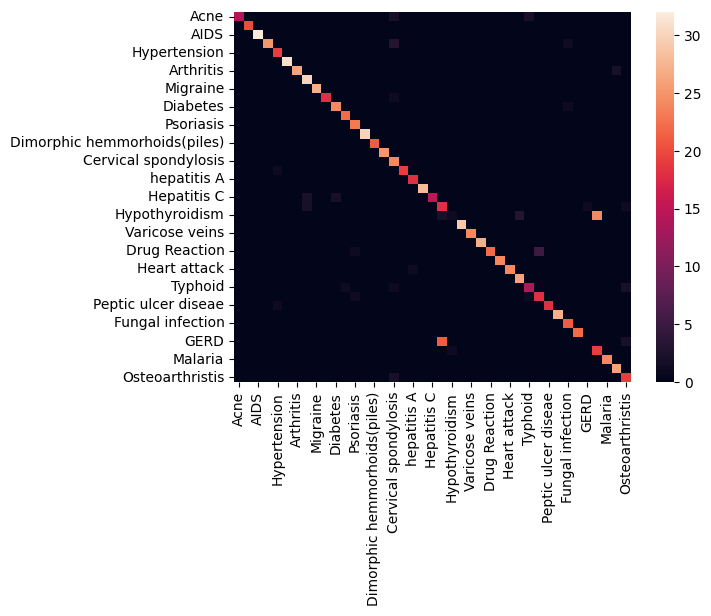

In [30]:
tree =DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=13)
tree.fit(x_train, y_train)
preds=tree.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [31]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_train =cross_val_score(tree, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_train.mean()*100.0, DS_train.std()*100.0))

Mean Accuracy: 90.624%, Standard Deviation: (1.08%)


In [32]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_test =cross_val_score(tree, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_test.mean()*100.0, DS_test.std()*100.0))

Mean Accuracy: 86.882%, Standard Deviation: (3.00%)


# Random Forest

In [33]:
rfc=RandomForestClassifier(random_state=42)

[3 5 3 5]
Migraine
F1-score% = 89.39535517208402 | Accuracy% = 91.05691056910568


<Axes: >

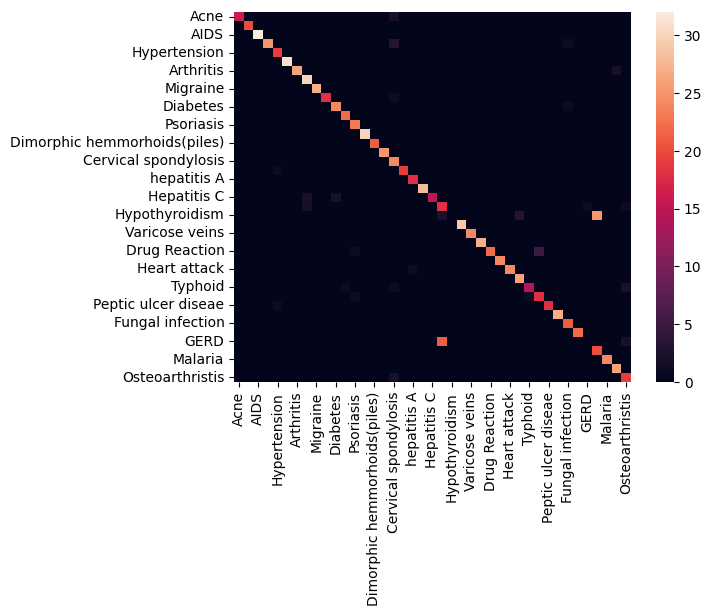

In [34]:
rnd_forest = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13)
rnd_forest.fit(x_train,y_train)
preds=rnd_forest.predict(x_test)
print(x_test[0])
print(preds[0])
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [35]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_train =cross_val_score(rnd_forest, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_train.mean()*100.0, rnd_forest_train.std()*100.0))

Mean Accuracy: 90.878%, Standard Deviation: (1.08%)


In [36]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_test =cross_val_score(rnd_forest, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_test.mean()*100.0, rnd_forest_test.std()*100.0))

Mean Accuracy: 87.899%, Standard Deviation: (3.29%)


# Fucntion to manually test the models

**Save Random Forest model**

In [39]:
# save
joblib.dump(rnd_forest, "../models/rf_QuickCheckup.joblib")


['../models/rf_QuickCheckup.joblib']